In [4]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d
import numpy as np
import open3d as o3d
import seaborn as sns
from scipy import spatial
from tqdm.auto import tqdm

from pspd.points import remove_hidden_points
from pspd.misc import edblquad

In [5]:
%matplotlib widget

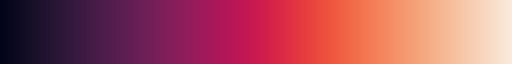

In [6]:
# constants
elev = 25
azim = 50
cmap = sns.color_palette('rocket', as_cmap=True)
cmap

In [69]:
# data
fname = os.path.join('data', 'model', 'head.scaled')
points = np.loadtxt(fname + '.xyz') 
normals = np.loadtxt(fname + '.normals')
mesh = o3d.io.read_triangle_mesh(fname + '.iso.watertight.off')
vert = np.asarray(mesh.vertices)
tri = np.asarray(mesh.triangles)

# Algorithm for the automatic detection of the psPD

In [17]:
def generate_power_density(amplitude,
                           radius,
                           query_point,
                           points,
                           scaler=[1, 1, 1]):
    distance = np.linalg.norm((points - query_point)
                              / np.array(scaler),
                          axis=1)
    return amplitude * np.exp(-(distance / radius) ** 2)

In [140]:
amplitude = 10
radius = 2.5
query_point = points[points[:, 0].argmax(), :].copy()
query_point -= np.array([0, 0, 1])
power_density = generate_power_density(amplitude,
                                       radius,
                                       query_point,
                                       points,
                                       scaler=[1, 0.5, 0.25])

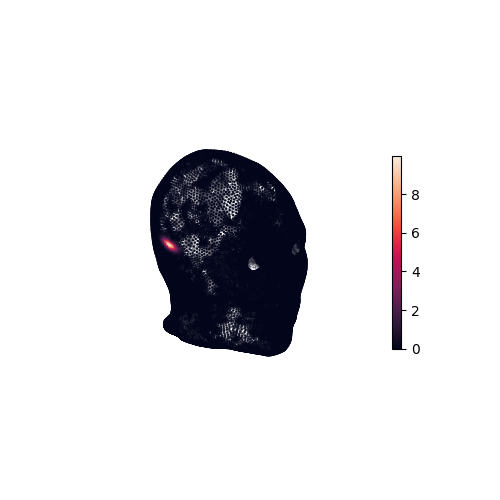

In [141]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, c=power_density, cmap=cmap, s=0.5)
cbar = fig.colorbar(s, ax=ax, pad=0, shrink=0.5)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set(xlabel='x', ylabel='y')
ax.set_axis_off()
ax.view_init(25, 50)
plt.show()

In [142]:
pov = np.mean(points, axis=0)
diameter = np.linalg.norm(points.ptp(axis=0))
pov[0] += 2 * diameter
pov[1] += 0.5 * diameter

projected_area = 4
a = np.sqrt(projected_area)

from pspd import PSPD

pspd = PSPD(points, power_density, mesh=mesh)
pspd.find(projected_area, pov=pov, p=np.pi)

  0%|          | 0/24995 [00:00<?, ?it/s]

In [143]:
res = pspd.get_results()
p = res['query point']
nbh = res['k-neigborhood']
nbh_mesh = res['evaluation surface']
area = res['surface area']
pd = res['power density']
spd = res['spatially averaged power density']

In [144]:
spd, area

(5.010380488191482, 3.5762267962827)

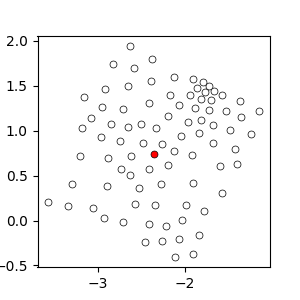

In [149]:
plt.close()
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.scatter(*nbh[(nbh != p).all(axis=1), 1:].T,
           fc='w', ec='k', s=25, lw=0.5)
ax.scatter(*p[1:],
           fc='r', ec='k', s=25, lw=0.5)
plt.show()

In [146]:
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.ptp(nbh[:, 2]))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)
angle

22.865510149141052

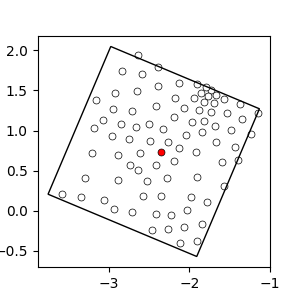

In [150]:
plt.close()
square = Rectangle(xy=(ymin + 0.05 * ymin, z_at_ymin),
                   width=a,
                   height=a,
                   angle=-angle,
                   ec='k', fc='none')
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.scatter(*nbh[(nbh != p).all(axis=1), 1:].T,
           fc='w', ec='k', s=25, lw=0.5)
ax.scatter(*p[1:],
           fc='r', ec='k', s=25, lw=0.5)
ax.add_patch(square)
plt.show()

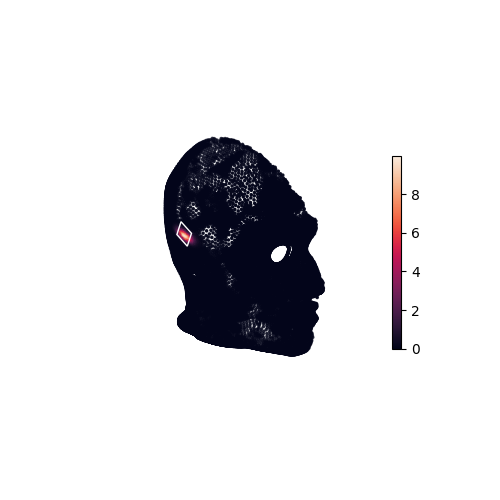

In [152]:
# point cloud - search space
ind, _ = pspd.get_points()

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
s = ax.scatter(*points[ind].T, c=power_density[ind], cmap=cmap, s=2.5)
cbar = fig.colorbar(s, ax=ax, pad=0, shrink=0.5)
square = Rectangle(xy=(ymin + 0.05 * ymin, z_at_ymin),
                   width=a,
                   height=a,
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=query_point[0], zdir='x')
ax.set_box_aspect(np.ptp(points[ind], axis=0))
ax.set(xlabel='x', ylabel='y')
ax.set_axis_off()
ax.view_init(25, 50)
plt.show()